In [1]:
import utils
import plotting
import numpy as np
import warnings
import pandas as pd
from pathlib import Path

from pandas.errors import SettingWithCopyWarning
from HHbbVV.hh_vars import data_key, years
import postprocessing

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfMerger

from copy import deepcopy

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = Path("../../../plots/ttsfs/24Aug1Distortion")
plot_dir.mkdir(parents=True, exist_ok=True)

## Load samples

In [ ]:
bg_samples = {
    "QCD": "QCD",
    "SingleTop": ["ST"],
    "TTbar": ["TTTo2L2Nu", "TTToHadronic"],
    "W+Jets": "WJets",
    "Diboson": ["WW", "WZ", "ZZ"],
    "Data": "SingleMuon",
}

sig_samples = {"Top": ["TTToSemiLeptonic"]}

samples = {**bg_samples, **sig_samples}

top_matched_key = "TT Top Matched"

# data_dir = "../../../../data/ttsfs/24Feb28_update_lp/"
data_dir = "/ceph/cms/store/user/rkansal/bbVV/ttsfs/24Feb28_update_lp/"
signal_data_dir = "/ceph/cms/store/user/rkansal/bbVV/ttsfs/24Jul23BLDistortion/"
year = "2018"

# filters = [("('ak8FatJetPt', '0')", ">=", 500)]
filters = None

events_dict = postprocessing.load_samples(data_dir, bg_samples, year, hem_cleaning=False)
events_dict |= postprocessing.load_samples(signal_data_dir, sig_samples, year, hem_cleaning=False)

cutflow = pd.DataFrame(index=list(samples.keys()))
utils.add_to_cutflow(events_dict, "Selection", "weight", cutflow)
cutflow

HEM Veto Efficiency

In [ ]:
tot_pre = 0
tot_hem = 0
for run in ["A", "B", "C", "D"]:
    cf = utils.get_pickles(
        f"{data_dir}/{year}/SingleMuon_Run2018{run}/pickles", year, f"SingleMuon_Run2018{run}"
    )["cutflow"]
    tot_pre += cf["ak4_jet"]
    tot_hem += cf["hem_cleaning"]

print(tot_hem / tot_pre)

### Normalization

In [ ]:
scale_samples = ["Top", "TTbar", "SingleTop", "W+Jets"]  # normalizations are off

total_scale = 0
total_noscale = 0
for sample, events in events_dict.items():
    if sample in scale_samples:
        total_scale += events["weight"].sum().values[0]
    elif sample != "Data":
        total_noscale += events["weight"].sum().values[0]

print(f"Total MC: {total_scale + total_noscale}")

sf = (events_dict["Data"]["weight"].sum().values[0] - total_noscale) / total_scale
for sample, events in events_dict.items():
    if sample in scale_samples:
        events["weight"] *= sf

total = 0
for sample, events in events_dict.items():
    if sample != "Data":
        total += events["weight"].sum().values[0]

print(f"New Total MC: {total}")

In [ ]:
utils.add_to_cutflow(events_dict, "Scale", "weight", cutflow)
cutflow

### Selection

In [ ]:
for key in events_dict:
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetPt"][0] >= 500]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] >= 125]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] <= 225]

In [ ]:
events_dict[top_matched_key] = events_dict["Top"].loc[events_dict["Top"]["top_matched"][0] == 1]
events_dict["TT W Matched"] = events_dict["Top"].loc[events_dict["Top"]["w_matched"][0] == 1]
events_dict["TT Unmatched"] = pd.concat(
    [
        events_dict["TTbar"],
        # events_dict["SingleTop"],
        events_dict["Top"].loc[events_dict["Top"]["unmatched"][0] == 1],
    ]
)
# del events_dict["Top"]
# del events_dict["TTbar"]

In [ ]:
print(np.sum(events_dict[top_matched_key]["weight"]))
print(np.sum(events_dict["TT W Matched"]["weight"]))
print(np.sum(events_dict["TT Unmatched"]["weight"]))

## LP SF Processing

In [ ]:
CLIP = 5.0

events = events_dict[top_matched_key]

up_prong_rc = (
    (events["lp_sf_outside_boundary_quarks"][0] > 0)
    | (events["lp_sf_double_matched_event"][0] > 0)
    | (events["lp_sf_unmatched_quarks"][0] > 0)
).to_numpy()

down_prong_rc = (
    (events["lp_sf_inside_boundary_quarks"][0] > 0)
    | (events["lp_sf_double_matched_event"][0] > 0)
    | (events["lp_sf_unmatched_quarks"][0] > 0)
).to_numpy()

rc_unmatched = events["lp_sf_rc_unmatched_quarks"][0] > 0

for shift, prong_rc in [("up", up_prong_rc), ("down", down_prong_rc)]:
    np_sfs = events["lp_sf_lnN"][0].to_numpy()
    np_sfs[prong_rc] = events[f"lp_sf_np_{shift}"][0][prong_rc]
    np_sfs = np.nan_to_num(np.clip(np_sfs, 1.0 / CLIP, CLIP))
    events.loc[:, (f"lp_sf_np_{shift}", 0)] = np_sfs / np.mean(np_sfs, axis=0)

for shift in ["up", "down"]:
    np_sfs = events["lp_sf_lnN"][0].to_numpy()
    np_sfs[rc_unmatched] = CLIP if shift == "up" else 1.0 / CLIP
    np_sfs = np.nan_to_num(np.clip(np_sfs, 1.0 / CLIP, CLIP))
    events[f"lp_sf_unmatched_{shift}"] = np_sfs / np.mean(np_sfs, axis=0)

In [ ]:
print(np.mean(rc_unmatched))
print(np.mean(events["lp_sf_unmatched_quarks"][0] > 0))

### Normalization

In [ ]:
# normalize scale factors to average to 1
for key in [
    # "lp_sf",
    "lp_sf_lnN",
    "lp_sf_sys_down",
    "lp_sf_sys_up",
    "lp_sf_dist_down",
    "lp_sf_dist_up",
    "lp_sf_pt_extrap_vars",
    "lp_sfs_bl_ratio",
]:
    # cut off at 5
    events_dict[top_matched_key].loc[:, key] = np.clip(
        events_dict[top_matched_key].loc[:, key].values, 1.0 / 5.0, 5.0
    )

    if key == "lp_sfs_bl_ratio":
        mean_lp_sfs = np.mean(
            np.nan_to_num(
                events_dict[top_matched_key][key][0] * events_dict[top_matched_key]["lp_sf_lnN"][0]
            ),
            axis=0,
        )
    else:
        mean_lp_sfs = np.mean(np.nan_to_num(events_dict[top_matched_key][key]), axis=0)

    events_dict[top_matched_key].loc[:, key] = (
        np.nan_to_num(events_dict[top_matched_key].loc[:, key]) / mean_lp_sfs
    )

In [ ]:
plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
_ = plt.hist(
    events_dict[top_matched_key]["lp_sf_lnN"][10].values,
    np.logspace(-4, 2, 101, base=10),
    histtype="step",
)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("LP SF")
plt.title("Scale factor distribution")
plt.show()

In [ ]:
# events = events_dict[top_matched_key]
# sj_matching_unc = (
#     (np.sum(events["lp_sf_unmatched_quarks"]) / (len(events) * 3))
#     # OR of double matched and boundary quarks
#     # >0.1 to avoid floating point errors
#     + (
#         np.sum((events["lp_sf_double_matched_event"] + events["lp_sf_boundary_quarks"]) > 0.1)
#         / (len(events))
#     )
# ).values[0]
# sj_matching_unc

### Testing distortion uncertainty

In [18]:
import uproot
from tqdm import tqdm
import pickle

package_path = Path("../")

for dist_year in tqdm(years[-1:]):
    f = uproot.open(package_path / f"corrections/lp_ratios/ratio_{dist_year}.root")

    # 3D histogram: [subjet_pt, ln(0.8/Delta), ln(kT/GeV)]
    mc_nom = f["mc_nom"].to_numpy()
    ratio_edges = mc_nom[1:]
    mc_nom = mc_nom[0]

    mc_tot_pt = np.sum(mc_nom, axis=(1, 2), keepdims=True)
    mc_density = mc_nom / mc_tot_pt
    plotting.plot_lund_plane_six(
        mc_density, ratio_edges, name=f"{plot_dir}/{dist_year}_MC.pdf", show=False
    )

    # ratio_nom = f["ratio_nom"].to_numpy()[0]

    for sig in ["GluGluToHHTobbVV_node_cHHH1", "VBF_HHTobbVV_CV_1_C2V_2_C3_1", "TTToSemiLeptonic"]:
        if sig == "TTToSemiLeptonic" and dist_year != "2018":
            continue

        with (package_path / f"corrections/lp_ratios/signals/{dist_year}_{sig}.hist").open(
            "rb"
        ) as f:
            sig_lp_hist = pickle.load(f)

        # sig_lp_hist = sig_lp_hist * top_mc_sig_ratio
        sig_tot_pt = np.sum(sig_lp_hist.values(), axis=(1, 2), keepdims=True)
        sig_density = sig_lp_hist.values() / sig_tot_pt * tot_mc_sig_ratio

        mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
        mc_sig_ratio[mc_sig_ratio == 0] = 1.0
        mc_sig_ratio = np.clip(mc_sig_ratio, 0.2, 5.0)

        plotting.plot_lund_plane_six(
            sig_density,
            ratio_edges,
            name=f"{plot_dir}/{dist_year}_{sig}_tt_reweighted.pdf",
            show=False,
        )
        plotting.plot_lund_plane_six(
            mc_sig_ratio,
            ratio_edges,
            name=f"{plot_dir}/{dist_year}_{sig}_ratio_tt_reweighted.pdf",
            show=False,
        )

        # break

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: divide by zero encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: invalid value encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: divide by zero encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: invalid value encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: divide by zero encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/2885276534.py:36: RuntimeWarning: invalid value encountered in divide
  mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
100%|██████████| 1/1 [00:23<00:00, 23.42s/it]


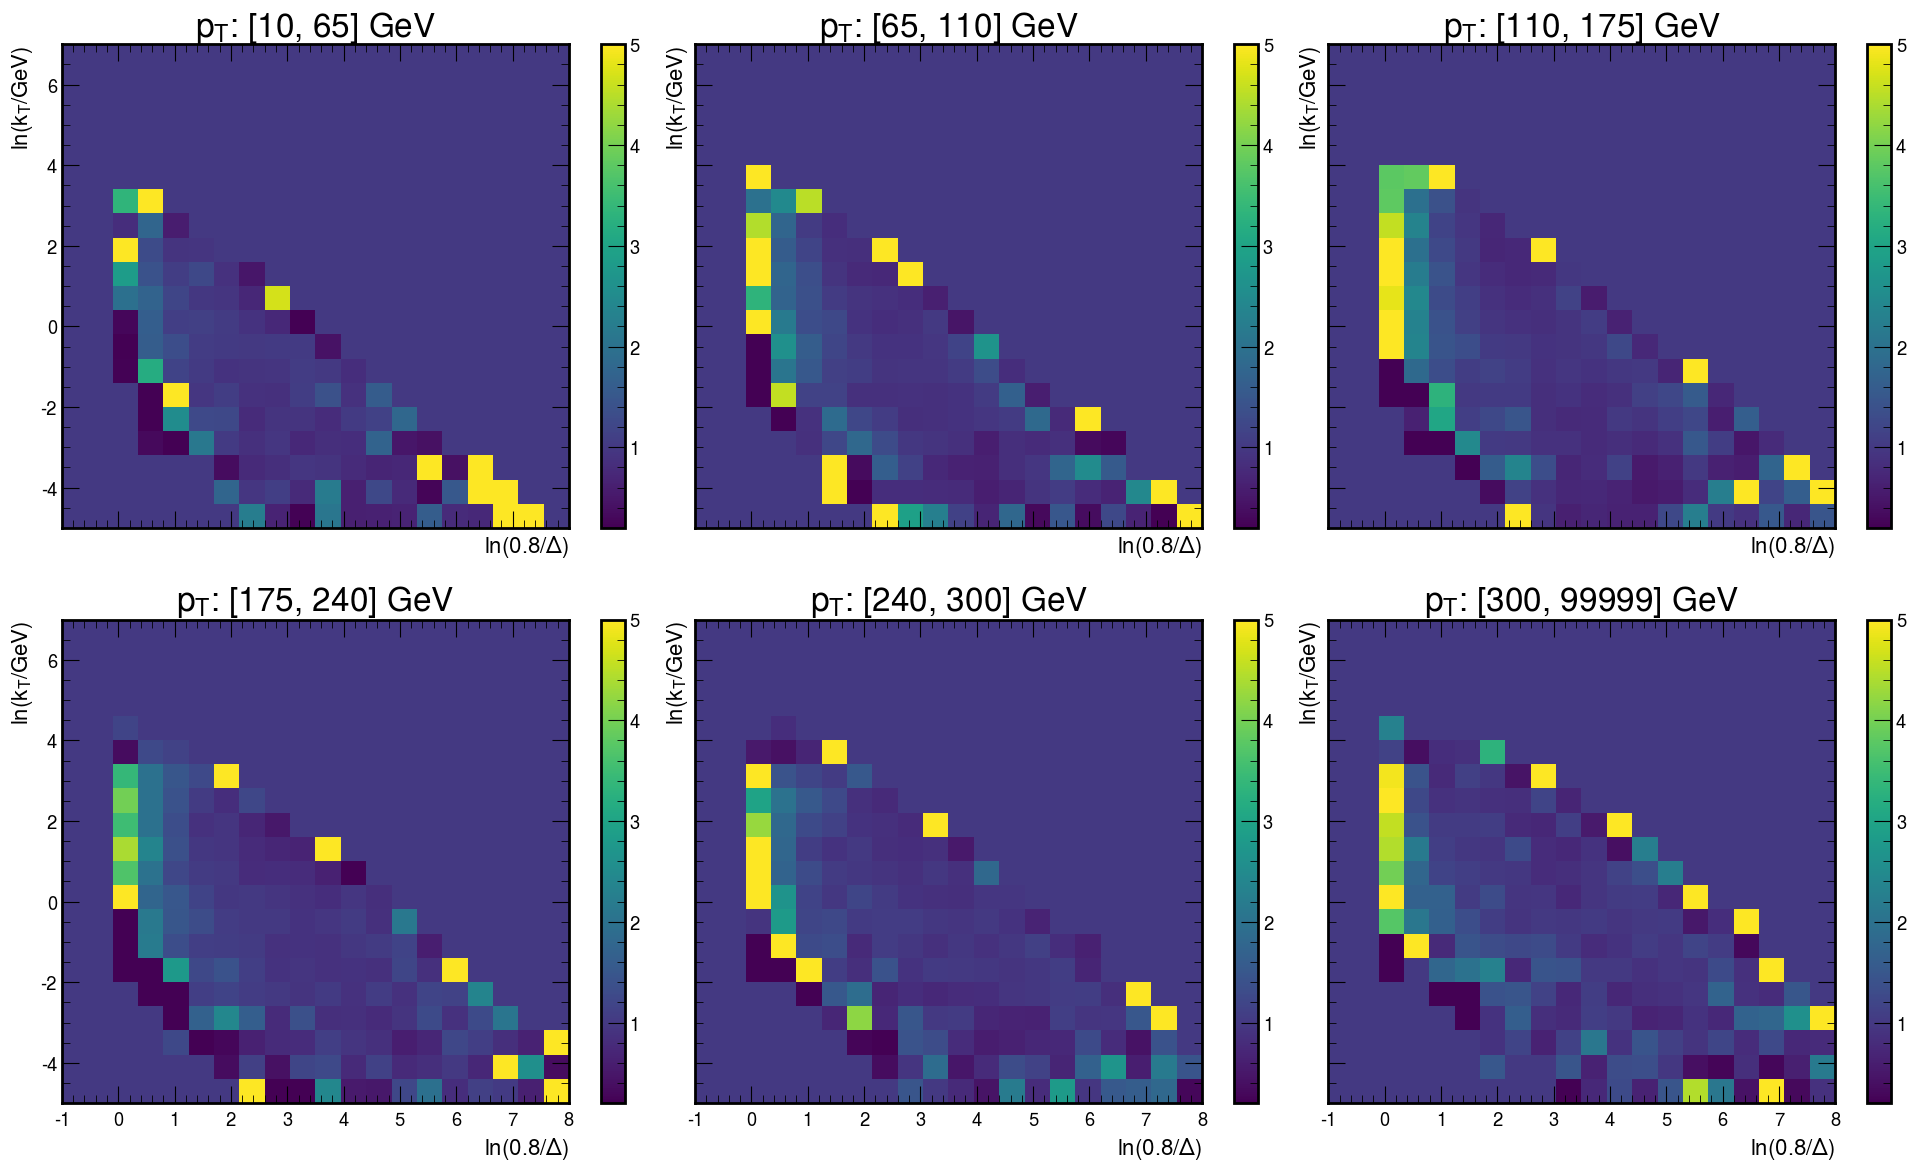

In [17]:
plotting.plot_lund_plane_six(
    top_mc_sig_ratio,
    ratio_edges,
    name=f"{plot_dir}/tt_ratio.pdf",
    show=True,
)

In [16]:
f = uproot.open(package_path / f"corrections/lp_ratios/top_RW_2018_june17_ratio.root")

mc_nom = f["mc_nom"].to_numpy()
ratio_edges = mc_nom[1:]
mc_nom = mc_nom[0]

mc_tot_pt = np.sum(mc_nom, axis=(1, 2), keepdims=True)
mc_density = mc_nom / mc_tot_pt
plotting.plot_lund_plane_six(
    mc_density, ratio_edges, name=f"{plot_dir}/2018_top_MC.pdf", show=False
)

with (package_path / f"corrections/lp_ratios/signals/2018_TTToSemiLeptonic.hist").open("rb") as f:
    sig_lp_hist = pickle.load(f)

    sig_tot_pt = np.sum(sig_lp_hist.values(), axis=(1, 2), keepdims=True)
    sig_density = sig_lp_hist.values() / sig_tot_pt

    top_mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
    top_mc_sig_ratio[top_mc_sig_ratio == 0] = 1.0
    top_mc_sig_ratio = np.clip(mc_sig_ratio, 0.05, 20.0)

/tmp/ipykernel_441066/1362833123.py:19: RuntimeWarning: divide by zero encountered in divide
  top_mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)
/tmp/ipykernel_441066/1362833123.py:19: RuntimeWarning: invalid value encountered in divide
  top_mc_sig_ratio = np.nan_to_num(mc_density / sig_density, nan=1.0)


In [13]:
top_mc_sig_ratio

array([[[1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        ...,
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000]],

       [[1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+

In [6]:
f.keys()

['ratio_nom;3',
 'ratio_nom;2',
 'ratio_nom;1',
 'mc_nom;1',
 'bkg_nom;1',
 'data;1',
 'ratio_pdf_up;1',
 'ratio_pdf_down;1',
 'ratio_prefire_up;1',
 'ratio_prefire_down;1',
 'ratio_pileup_up;1',
 'ratio_pileup_down;1',
 'ratio_btag_up;1',
 'ratio_btag_down;1',
 'ratio_PS_ISR_up;1',
 'ratio_PS_ISR_down;1',
 'ratio_PS_FSR_up;1',
 'ratio_PS_FSR_down;1',
 'ratio_ttbar_F_up;1',
 'ratio_ttbar_F_down;1',
 'ratio_ttbar_R_up;1',
 'ratio_ttbar_R_down;1',
 'ratio_ttbar_RF_up;1',
 'ratio_ttbar_RF_down;1',
 'ratio_QCD_F_up;1',
 'ratio_QCD_F_down;1',
 'ratio_QCD_R_up;1',
 'ratio_QCD_R_down;1',
 'ratio_QCD_RF_up;1',
 'ratio_QCD_RF_down;1',
 'ratio_tW_F_up;1',
 'ratio_tW_F_down;1',
 'ratio_tW_R_up;1',
 'ratio_tW_R_down;1',
 'ratio_tW_RF_up;1',
 'ratio_tW_RF_down;1',
 'ratio_Single_F_up;1',
 'ratio_Single_F_down;1',
 'ratio_Single_R_up;1',
 'ratio_Single_R_down;1',
 'ratio_Single_RF_up;1',
 'ratio_Single_RF_down;1',
 'ratio_diboson_F_up;1',
 'ratio_diboson_F_down;1',
 'ratio_diboson_R_up;1',
 'ratio_d

In [ ]:
sig_lp_hist.values()

In [ ]:
import hist

h = hist.Hist(
    hist.axis.Variable(ratio_edges[0], name="subjet_pt", label="Subjet pT [GeV]"),
    hist.axis.Variable(ratio_edges[1], name="logD", label="ln(0.8/Delta)"),
    hist.axis.Variable(ratio_edges[2], name="logkt", label="ln(kT/GeV)"),
    storage=hist.storage.Weight(),
)

In [ ]:
h.variances()

In [ ]:
mc_tot = np.sum(mc_nom)
sig_tot = sig_lp_hist.sum()
sig_mc_ratio = np.clip(
    np.nan_to_num((sig_lp_hist.values() / sig_tot) / (mc_nom / mc_tot), nan=1), 0.5, 2.0
)

In [ ]:
print(np.mean(mc_sig_ratio_pt, axis=(1, 2)))
print(np.mean(mc_sig_old_ratio_pt, axis=(1, 2)))

In [ ]:
sig_tot_pt = np.sum(sig_lp_hist.values(), axis=(1, 2), keepdims=True)
mc_tot_pt = np.sum(mc_nom, axis=(1, 2), keepdims=True)
mc_sig_ratio_pt = np.nan_to_num((mc_nom / mc_tot_pt) / (sig_lp_hist.values() / sig_tot_pt), nan=1.0)
mc_sig_ratio_pt[mc_sig_ratio_pt == 0] = 1.0
mc_sig_ratio_pt = np.clip(mc_sig_ratio_pt, 0.5, 2.0)
plt.imshow(mc_sig_ratio_pt[0])

In [ ]:
sig_tot_pt = np.sum(sig_old_lp_hist.values(), axis=(1, 2), keepdims=True)
mc_tot_pt = np.sum(mc_nom, axis=(1, 2), keepdims=True)
mc_sig_old_ratio_pt = np.nan_to_num(
    (mc_nom / mc_tot_pt) / (sig_old_lp_hist.values() / sig_tot_pt), nan=1.0
)
mc_sig_old_ratio_pt[mc_sig_old_ratio_pt == 0] = 1.0
mc_sig_old_ratio_pt = np.clip(mc_sig_old_ratio_pt, 0.5, 2.0)
plt.imshow(mc_sig_old_ratio_pt[0])

## Plots

In [ ]:
plot_samples = [
    "QCD",
    "Diboson",
    # "Single Top",
    "W+Jets",
    "TT Unmatched",
    "TT W Matched",
    top_matched_key,
]

bg_colours = {
    "QCD": "lightblue",
    "Single Top": "darkblue",
    "TT Unmatched": "darkgreen",
    "TT W Matched": "green",
    "TT Top Matched": "orange",
    "W+Jets": "darkred",
    "Diboson": "red",
}

### Pre plots

In [ ]:
# {var: (bins, label)}
plot_vars = {
    # "ak8FatJetMsd": ([20, 125, 225], r"$m_{SD}$ (GeV)"),
    # "ak8FatJetParticleNetMass": ([30, 50, 200], r"$m_{reg}$ (GeV)"),
    # "ak8FatJetPt": ([30, 0, 1200], r"$p_T$ (GeV)"),
    # "MET_pt": ([30, 0, 200], r"MET (GeV)"),
    # "ak8FatJetnPFCands": ([20, 0, 120], r"# of PF Candidates"),
    # "ak8FatJetParticleNet_Th4q": ([20, 0.6, 1], r"ParticleNet $T_{H4q}$ Non-MD"),
    "ak8FatJetParTMD_THWW4q": ([20, 0.2, 1], r"$T_{HVV}$"),
    # "tau21": ([20, 0.04, 0.8], r"$\tau_{21}$"),
    # "tau32": ([20, 0.2, 1], r"$\tau_{32}$"),
    # "tau43": ([20, 0.42, 1], r"$\tau_{43}$"),
    # "tau42": ([20, 0, 1], r"$\tau_{42}$"),
    # "tau41": ([20, 0, 1], r"$\tau_{41}$"),
}

pre_hists = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists:
        pre_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfMerger()

for var, var_hist in pre_hists.items():
    name = f"{plot_dir}/pre_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        # bg_err=None,
        name=name,
        bg_colours=bg_colours,
        # bg_order=plot_samples,
        # ratio_ylims=[0.6, 1.3],
    )
    merger_pre_plots.append(name)

merger_pre_plots.write(f"{plot_dir}/PrePlots.pdf")
merger_pre_plots.close()

### Post plots

In [ ]:
post_hists = {}
post_hists_err = {}
uncs_dict = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    # if var not in post_hists:
    toy_hists = []
    for i in range(events["lp_sf"].shape[1]):
        toy_hists.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events["lp_sf"][i].values,
            )[0]
        )

    sys_up_down = []
    for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
        sys_up_down.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events[key][0].values,
            )[0]
        )

    np_up_down = []
    for key in ["lp_sf_np_up", "lp_sf_np_down"]:
        np_up_down.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events[key][0].values,
            )[0]
        )

    um_up_down = []
    for key in ["lp_sf_unmatched_up", "lp_sf_unmatched_down"]:
        um_up_down.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events[key].values,
            )[0]
        )

    nom_vals = toy_hists[0]  # first column are nominal values

    pt_toy_hists = []
    for i in range(events["lp_sf_pt_extrap_vars"].shape[1]):
        pt_toy_hists.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events["lp_sf_pt_extrap_vars"][i].values,
            )[0]
        )

    b_ratio_hist = np.histogram(
        events[var][0].values.squeeze(),
        np.linspace(*bins[1:], bins[0] + 1),
        weights=events["weight"][0].values
        * events["lp_sfs_bl_ratio"][0].values
        * events["lp_sf_lnN"][0].values,
    )[0]

    uncs = {
        "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
        "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
        "np_unc": np.minimum(nom_vals, (np.abs(np_up_down[0] - np_up_down[1])) / 2),
        "um_unc": np.minimum(nom_vals, (np.abs(um_up_down[0] - um_up_down[1])) / 2),
        # "syst_sjm_unc": nom_vals * sj_matching_unc,
        "syst_sjpt_unc": np.minimum(nom_vals, np.std(pt_toy_hists, axis=0)),
        "syst_b_unc": np.abs(1 - (b_ratio_hist / nom_vals)) * nom_vals,
    }

    # uncs = {}

    # for i, shift in enumerate(["up", "down"]):
    #     uncs[shift] = {
    #         "syst_rat_unc": np.clip(sys_up_down[i], 0, 2 * nom_vals),
    #         "np_unc": np.clip(np_up_down[i], 0, 2 * nom_vals),
    #         "um_unc": np.clip(um_up_down[i], 0, 2 * nom_vals),
    #     }

    #     uncs[shift]

    #     for key, val in uncs_symm.items():
    #         if shift == "up":
    #             uncs[shift][key] = nom_vals + val
    #         else:
    #             uncs[shift][key] = nom_vals - val

    uncs_dict[var] = uncs

    unc = np.linalg.norm(list(uncs.values()), axis=0)

    thist = deepcopy(pre_hists[var])
    top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
    thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
    post_hists[var] = thist
    post_hists_err[var] = unc


merger_post_plots = PdfMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/post_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_colours=bg_colours,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostPlots.pdf")
merger_post_plots.close()

### Post LnN Plots

In [ ]:
post_lnN_hists = {}
post_lnN_hists_err = {}
uncs_lnN_dict = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_lnN_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        sys_up_down = []
        for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
            sys_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events[key][0].values,
                )[0]
            )

        np_up_down = []
        for key in ["lp_sf_np_up", "lp_sf_np_down"]:
            np_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * np.nan_to_num(events[key][0].values),
                )[0]
            )

        dist_up_down = []
        for key in ["lp_sf_dist_up", "lp_sf_dist_down"]:
            dist_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * np.nan_to_num(events[key][0].values),
                )[0]
            )

        um_up_down = []
        for key in ["lp_sf_unmatched_up", "lp_sf_unmatched_down"]:
            um_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * np.nan_to_num(events[key].values),
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values

        pt_toy_hists = []
        for i in range(events["lp_sf_pt_extrap_vars"].shape[1]):
            pt_toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_pt_extrap_vars"][i].values,
                )[0]
            )

        b_ratio_hist = np.histogram(
            events[var][0].values.squeeze(),
            np.linspace(*bins[1:], bins[0] + 1),
            weights=events["weight"][0].values
            * events["lp_sfs_bl_ratio"][0].values
            * events["lp_sf_lnN"][0].values,
        )[0]

        uncs = {
            "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
            "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
            "np_unc": np.minimum(nom_vals, (np.abs(np_up_down[0] - np_up_down[1])) / 2),
            "dist_unc": np.minimum(nom_vals, (np.abs(dist_up_down[0] - dist_up_down[1])) / 2),
            "um_unc": np.minimum(nom_vals, (np.abs(um_up_down[0] - um_up_down[1])) / 2),
            # "syst_sjm_unc": nom_vals * sj_matching_unc,
            "syst_sjpt_unc": np.minimum(nom_vals, np.std(pt_toy_hists, axis=0)),
            "syst_b_unc": np.abs(1 - (b_ratio_hist / nom_vals)) * nom_vals,
        }

        uncs_lnN_dict[var] = uncs

        unc = np.linalg.norm(list(uncs.values()), axis=0)

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_lnN_hists[var] = thist

        post_lnN_hists_err[var] = unc


merger_post_plots = PdfMerger()

for var, var_hist in post_lnN_hists.items():
    name = f"{plot_dir}/postlnN_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_colours=bg_colours,
        bg_err=post_lnN_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostLnNPlots.pdf")
merger_post_plots.close()

## SF Analysis

In [ ]:
binn = -1
tvar = "ak8FatJetParTMD_THWW4q"
pre_vals = pre_hists[tvar].view(flow=False)[top_matched_key_index, :].value
nom_vals = post_hists[tvar].view(flow=False)[top_matched_key_index, :].value
unc = post_hists_err[tvar]
print("SF: ", nom_vals[binn] / pre_vals[binn])
print("Uncs: ", {key: val[binn] / nom_vals[binn] * 100 for key, val in uncs_dict[tvar].items()})
print("Combined: ", unc[binn] / nom_vals[binn] * 100)
print("Abs: ", unc[binn] / pre_vals[binn])

In [ ]:
binn = -1
tvar = "ak8FatJetParTMD_THWW4q"
pre_vals = pre_hists[tvar].view(flow=False)[top_matched_key_index, :].value
nom_vals = post_lnN_hists[tvar].view(flow=False)[top_matched_key_index, :].value
unc = post_lnN_hists_err[tvar]
print("SF: ", nom_vals[binn] / pre_vals[binn])
print("Uncs: ", {key: val[binn] / nom_vals[binn] * 100 for key, val in uncs_lnN_dict[tvar].items()})
print("Combined: ", unc[binn] / nom_vals[binn] * 100)
print("Abs: ", unc[binn] / pre_vals[binn])

### Chi^2 improvement

In [ ]:
def chisquare(mc, data):
    return np.sum(np.square(data - mc) / data)

In [ ]:
data_vals = pre_hists[tvar]["Data", ...].values()
pre_MC_vals = (
    pre_hists[tvar][sum, :].values()
    - data_vals
    - pre_hists[tvar]["TTbar", :].values()  # remove repeated data
    - pre_hists[tvar]["Top", :].values()
    - pre_hists[tvar]["SingleTop", :].values()
)
post_lnN_MC_vals = (
    post_lnN_hists[tvar][sum, :].values()
    - data_vals
    - post_lnN_hists[tvar]["TTbar", :].values()  # remove repeated data
    - post_lnN_hists[tvar]["Top", :].values()
    - post_lnN_hists[tvar]["SingleTop", :].values()
)

In [ ]:
lb = 10
print("Pre chi2:", chisquare(pre_MC_vals[-lb:], data_vals[-lb:]))
print("Post chi2:", chisquare(post_lnN_MC_vals[-lb:], data_vals[-lb:]))

In [ ]:
lb = 5
print("Pre chi2:", chisquare(pre_MC_vals[-lb:], data_vals[-lb:]))
print("Post chi2:", chisquare(post_lnN_MC_vals[-lb:], data_vals[-lb:]))

### Ratio plots

In [ ]:
tvar = "ak8FatJetParTMD_THWW4q"

# plt.figure(figsize=(12, 12))
# hists = pre_hists[tvar]
# bg_tot = np.sum(hists[plot_samples, :].values(), axis=0)
# mcdata_ratio = (bg_tot + 1e-5) / hists[data_key, :].values()
# _ = plt.hist(mcdata_ratio - 1, np.linspace(-0.5, 0.5, 10), histtype='step')

plt.figure(figsize=(12, 12))
hists = post_hists[tvar]
bg_tot = np.sum(hists[plot_samples, :].values(), axis=0)
data_tot = hists[data_key, :].values()
unc = post_hists_err[tvar]
mcdata_ratio = (bg_tot) / data_tot
_ = plt.hist(((bg_tot - data_tot) / (unc))[10:], np.linspace(-6.5, 4.5, 23), histtype="step")
plt.xlabel("(MC - Data) / Unc.")
plt.savefig(f"{plot_dir}/pull_hist.pdf")

In [ ]:
plotting.ratioLinePlot(
    post_hists[tvar],
    plot_samples,
    year,
    bg_err=post_hists_err[tvar],
    name=f"{plot_dir}/post_ak8FatJetParTMD_THWW4q_pulls.pdf",
    pulls=True,
)

In [ ]:
cut_dict = {}

for key in events_dict:
    cut_dict[key] = events_dict[key][events_dict[key]["tau42"][0] <= 0.3]

In [ ]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetParTMD_THWW4q": ([20, 0.6, 1], r"ParT $T_{HWW4q}$ MD"),
}

pre_hists_cut = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists_cut:
        pre_hists_cut[var] = utils.singleVarHistNoMask(
            cut_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists_cut.items():
    name = f"{plot_dir}/pre_{var}_tau42_cut.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=None,
        name=name,
    )
    merger_pre_plots.append(name)

In [ ]:
post_lnN_cut_hists = {}
post_lnN_cut_hists_err = {}
uncs_lnN_cut_dict = {}

events = cut_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_lnN_cut_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        sys_up_down = []
        for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
            sys_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events[key][0].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values

        uncs = {
            "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
            "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
            "syst_sjm_unc": nom_vals * sj_matching_unc,
            "syst_sjpt_unc": nom_vals * sj_pt_unc,
        }

        uncs_lnN_cut_dict[var] = uncs

        unc = np.linalg.norm(list(uncs.values()), axis=0)

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_lnN_cut_hists[var] = thist

        post_lnN_cut_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_lnN_cut_hists.items():
    name = f"{plot_dir}/postlnN_{var}_cut.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_lnN_cut_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

In [ ]:
mass_hist = utils.singleVarHistNoMask(
    events_dict, "ak8FatJetMass", [20, 125, 225], r"$m_{SD}$", weight_key="weight"
)

In [ ]:
plotting.ratioHistPlot(
    mass_hist,
    ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", top_matched_key],
    f"{plot_dir}/",
)